In [5]:
import mosaik
import mosaik.util
from pv_configurations import generate_configurations, Scenarios
import simbench
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd
import matplotlib
import nest_asyncio
import numpy as np
import re
import pandapower.networks as pn
import os
import sys

# Add local-mosaik-pandapower-2.src.mosaik_components to Python path
module_path = os.path.abspath(os.path.join(os.getcwd(), 'local-mosaik-pandapower-2', 'src'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

irradiation_module_path = os.path.abspath(os.path.join(os.getcwd(), 'irradiation_module'))
if irradiation_module_path not in sys.path:
    sys.path.insert(0, irradiation_module_path)

import irradiation_model


def getElementbyName(grid, name):
    """
    Get the element by name from the DataFrame.
    """
    for element in grid.children:
        if element.extra_info['name'] == name:
            return element
    return None    
#matplotlib.use("Qt5Agg")  # Use "Qt5Agg" if you have PyQt5 installed

# Simulator backends
SIM_CONFIG = {
    'ChargerSim': {        
        'python': 'mosaik_csv:CSV'
    },  
    'PVSim': {
            'python': 'mosaik_components.pv.pvsimulator:PVSimulator'
    },
    'CSV_writer': {
        'python': 'mosaik_csv_writer:CSVWriter',
    },
    "Pandapower": {
        'python': 'mosaik_components.pandapower:Simulator'
    },
    
    'SolarIrradiation': {
        'python': 'irradiation_model.SolarIrradiationModel:SolarIrradiationModel'
    }
}

START = "2024-12-01 00:15:00"
END = 3600 * 72
STEP_SIZE = 60 * 15
CHARGER_DATA = "./dados-solares-duilio.csv"

LAT = 32.0
AREA = 1
EFF = 0.5
EL = 32.0
AZ = 0.0

#this is needed to use mosaik on ipynbs
nest_asyncio.apply()

world = mosaik.World(SIM_CONFIG)


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ /
/      \____/  | | | | | | (_) \__ \ (_| | |   <
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\
 \____/      \____
 /    \      /    \     mosaik: 3.5.0
/      \____/      \       API: 3.0.13
\      /    \      /    Python: 3.13.3
 \____/      \____/         OS: Linux-6.5.0-1025-oem-x86_64-with-glibc2.36
      \      /            Docs: https://mosaik.readthedocs.io/en/3.5.0/
       \____/     Get in touch: https://github.com/orgs/OFFIS-mosaik/discussions



Connect Simulators Together

In [6]:

#Configure charger component
charger_sim = world.start("ChargerSim", sim_start=START, datafile=CHARGER_DATA)
charger_model = charger_sim.Charger1.create(1)
#meteo_model = meteo_sim.Braunschweig.create(1)

# Create PV system
# pv_count = 5
# pv_config = {str(i) : generate_configurations(Scenarios.HOUSE) for i in range(pv_count)}
# pv_sim = world.start(
#             "PVSim",
#             start_date=START,
#             step_size=STEP_SIZE,
#             pv_data=pv_config,
#         )
# pv_model = pv_sim.PVSim.create(pv_count)

# Power data output to test
csv_sim_writer = world.start('CSV_writer', start_date = START,
                                        output_file='results.csv')
csv_writer = csv_sim_writer.CSVWriter(buff_size = STEP_SIZE)

# Create PV system with certain configuration
pv_sim = world.start(
                    "PVSim",
                    start_date=START,
                    step_size=STEP_SIZE)

# Create PV system
pv_model = pv_sim.PV.create(1, latitude=LAT, area=AREA,
                          efficiency=EFF, el_tilt=EL, az_tilt=AZ)

#Instantiate the power network
# create empty net
pp_sim = world.start("Pandapower", step_size=STEP_SIZE, asymmetric_flow=True)

irradiation_sim = world.start("SolarIrradiation", sim_start=START, time_step=STEP_SIZE, date_format="%Y-%m-%d %H:%M:%S", type="time-based")
irr_model1 = irradiation_sim.SolarIrradiation(latitude=-25.4484, longitude=-49.2323)

net = pn.create_cigre_network_lv()

grid = pp_sim.Grid(net=net)


net.ext_grid['r0x0_max'] = 5.0
net.ext_grid['x0x_max'] = 5.0


# Add a new column to the net.line DataFrame
net.line['r0_ohm_per_km'] = net.line['r_ohm_per_km'] * 3
net.line['x0_ohm_per_km'] = net.line['x_ohm_per_km'] * 3
net.line['c0_nf_per_km'] = net.line['c_nf_per_km'] * 3

net.trafo['vector_group'] = 'Dyn'
net.trafo['vk0_percent'] = net.trafo['vk_percent']
net.trafo['mag0_percent'] = 100
net.trafo['mag0_rx'] = 0 
net.trafo['si0_hv_partial'] = 0.9
net.trafo['vkr0_percent'] = net.trafo['vkr_percent']

extra_info = pp_sim.get_extra_info()


loads = [e for e in grid.children if e.type == "Load"]    
buses = [e for e in grid.children if e.type == "Bus"] 
lines = [e for e in grid.children if e.type == "Line"]
trafos = [e for e in grid.children if e.type == "Transformer"] 


#connect a charger to B5
#charger1 = pp_sim.ControlledGen(bus=buses[1].extra_info['index'])
#charger1 = pp_sim.ControlledGen(bus=getElementbyName(grid,'B5').extra_info['index'])
generators = [e for e in grid.children if e.type == "StaticGen"] 

#output load Powers
for load in loads:
    world.connect(load, csv_writer, "P[MW]")

#output bus powers
for bus in buses:
    world.connect(bus, csv_writer, "P_a[MW]")    
    world.connect(bus, csv_writer, "Vm_a[pu]")
    world.connect(bus, csv_writer, "P_b[MW]")    
    world.connect(bus, csv_writer, "Vm_b[pu]")
    world.connect(bus, csv_writer, "P_c[MW]")    
    world.connect(bus, csv_writer, "Vm_c[pu]")
    world.connect(bus, csv_writer, "Unbalance[%]")
    
for trafo in trafos:
    world.connect(trafo, csv_writer, "Loading[%]")  


#output line information
for line in lines:
    world.connect(line, csv_writer, "I_a_from[kA]")
    world.connect(line, csv_writer, "I_b_from[kA]")
    world.connect(line, csv_writer, "I_c_from[kA]")
    world.connect(line, csv_writer, "I_n_from[kA]")
    world.connect(line, csv_writer, "Pl_a[MW]")
    world.connect(line, csv_writer, "Pl_b[MW]")
    world.connect(line, csv_writer, "Pl_c[MW]")
    world.connect(line, csv_writer, "Loading[%]")
    
#connect charger csv file to charger connection
world.connect(charger_model[0],getElementbyName(grid,'Bus C20'), ("P[MW]","P_a_gen[MW]"))

#plot solar panel power
world.connect(irr_model1, csv_writer, "DNI[W/m2]")
world.connect(irr_model1, pv_model[0],"DNI[W/m2]")

                
world.connect(
                    pv_model[0],
                    csv_writer,
                    "P[MW]",
                )
world.connect(pv_model[0],getElementbyName(grid,'Bus C20'), ("P[MW]","P_a_gen[MW]"))


2025-05-21 18:17:16.678 | INFO     | mosaik.async_scenario:start:420 - Starting "ChargerSim" as "ChargerSim-0" ...
2025-05-21 18:17:16.681 | INFO     | mosaik.async_scenario:start:420 - Starting "CSV_writer" as "CSV_writer-0" ...
2025-05-21 18:17:16.681 | INFO     | mosaik.async_scenario:start:420 - Starting "PVSim" as "PVSim-0" ...
2025-05-21 18:17:16.682 | INFO     | mosaik.async_scenario:start:420 - Starting "Pandapower" as "Pandapower-0" ...
2025-05-21 18:17:16.682 | INFO     | mosaik.async_scenario:start:420 - Starting "SolarIrradiation" as "SolarIrradiation-0" ...


Plot Network Topology

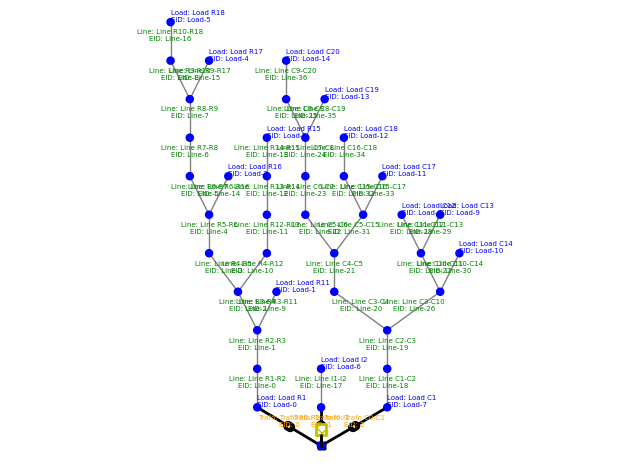

In [7]:
fig, ax = plt.subplots()
plot.simple_plot(net, ax=ax, show_plot=False)

# --- Annotate LOADS ---
for load in loads:
    load_data = net.load.iloc[load.extra_info['index']]
    x, y = net.bus_geodata.loc[load_data['bus'], ['x', 'y']]     
    ax.text(x, y, f'Load: {load_data['name']}\nEID: {load.eid}', fontsize=5, color='blue')

# --- Annotate LINES ---
for line in lines:
    line_data = net.line.iloc[line.extra_info['index']]
    fb, tb = line_data['from_bus'], line_data['to_bus']
    x1, y1 = net.bus_geodata.loc[fb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[tb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = line_data['name']
    ax.text(xm, ym, f'Line: {line_data['name']}\nEID: {line.eid}', fontsize=5, color='green', ha='center')

# --- Annotate TRANSFORMERS ---
for eid, trafo in net.trafo.iterrows():
    hb, lb = trafo.hv_bus, trafo.lv_bus
    x1, y1 = net.bus_geodata.loc[hb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[lb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = trafo['name']
    ax.text(xm, ym, f'Trafo: {name}\nEID: {eid}', fontsize=5, color='orange', ha='center')

# --- Annotate GENERATORS ---
for gen in generators:
    gen_data = net.sgen.iloc[gen.extra_info['index']]
    x, y = net.bus_geodata.loc[gen_data['bus'], ['x', 'y']]    
    ax.text(x + 5, y + 5, f'Gen: {gen_data['name']}\nEID: {gen.eid}', fontsize=5, color='red')

# --- Annotate SHUNTS ---
for eid, shunt in net.shunt.iterrows():
    bus = shunt.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = shunt['name'] 
    ax.text(x - 5, y - 5, f'Shunt: {name}\nEID: {eid}', fontsize=5, color='purple')

# --- Annotate STORAGE ---
for eid, storage in net.storage.iterrows():
    bus = storage.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = storage['name'] 
    ax.text(x + 5, y - 5, f'Storage: {name}\nEID: {eid}', fontsize=5, color='brown')

plt.tight_layout()
plt.savefig("topology.pdf")
plt.show()


Run the simulation

In [8]:
 # Run simulation
    
world.run(until=END)

2025-05-21 18:17:17.123 | INFO     | mosaik.async_scenario:run:789 - Starting simulation.
  0%|          | 361/259200 [00:00<01:11, 3608.27steps/s]

[SolarIrradiation-0] Step at t=0


  1%|          | 3061/259200 [00:01<01:31, 2801.35steps/s]

[SolarIrradiation-0] Step at t=900
[SolarIrradiation-0] Step at t=1800
[SolarIrradiation-0] Step at t=2700
[SolarIrradiation-0] Step at t=3600
[SolarIrradiation-0] Step at t=4500


  3%|▎         | 7201/259200 [00:01<00:34, 7236.72steps/s]

[SolarIrradiation-0] Step at t=5400
[SolarIrradiation-0] Step at t=6300
[SolarIrradiation-0] Step at t=7200
[SolarIrradiation-0] Step at t=8100
[SolarIrradiation-0] Step at t=9000


  5%|▍         | 11701/259200 [00:01<00:21, 11731.17steps/s]

[SolarIrradiation-0] Step at t=9900
[SolarIrradiation-0] Step at t=10800
[SolarIrradiation-0] Step at t=11700
[SolarIrradiation-0] Step at t=12600
[SolarIrradiation-0] Step at t=13500


  6%|▋         | 16561/259200 [00:02<00:15, 15726.25steps/s]

[SolarIrradiation-0] Step at t=14400
[SolarIrradiation-0] Step at t=15300
[SolarIrradiation-0] Step at t=16200
[SolarIrradiation-0] Step at t=17100
[SolarIrradiation-0] Step at t=18000


  9%|▉         | 22861/259200 [00:02<00:13, 17738.92steps/s]

[SolarIrradiation-0] Step at t=18900
[SolarIrradiation-0] Step at t=19800
[SolarIrradiation-0] Step at t=20700
[SolarIrradiation-0] Step at t=21600
[SolarIrradiation-0] Step at t=22500


 10%|█         | 26461/259200 [00:02<00:10, 21238.06steps/s]

[SolarIrradiation-0] Step at t=23400
[SolarIrradiation-0] Step at t=24300
[SolarIrradiation-0] Step at t=25200
[SolarIrradiation-0] Step at t=26100
[SolarIrradiation-0] Step at t=27000


 12%|█▏        | 30961/259200 [00:02<00:13, 17548.25steps/s]

[SolarIrradiation-0] Step at t=27900
[SolarIrradiation-0] Step at t=28800
[SolarIrradiation-0] Step at t=29700
[SolarIrradiation-0] Step at t=30600
[SolarIrradiation-0] Step at t=31500


 14%|█▎        | 35101/259200 [00:03<00:12, 17851.08steps/s]

[SolarIrradiation-0] Step at t=32400
[SolarIrradiation-0] Step at t=33300
[SolarIrradiation-0] Step at t=34200
[SolarIrradiation-0] Step at t=35100
[SolarIrradiation-0] Step at t=36000


 15%|█▌        | 39061/259200 [00:03<00:12, 17841.74steps/s]

[SolarIrradiation-0] Step at t=36900
[SolarIrradiation-0] Step at t=37800
[SolarIrradiation-0] Step at t=38700
[SolarIrradiation-0] Step at t=39600


 19%|█▊        | 48241/259200 [00:03<00:08, 23865.13steps/s]

[SolarIrradiation-0] Step at t=40500
[SolarIrradiation-0] Step at t=41400
[SolarIrradiation-0] Step at t=42300
[SolarIrradiation-0] Step at t=43200
[SolarIrradiation-0] Step at t=44100


 20%|█▉        | 50941/259200 [00:03<00:10, 20223.46steps/s]

[SolarIrradiation-0] Step at t=45000
[SolarIrradiation-0] Step at t=45900
[SolarIrradiation-0] Step at t=46800
[SolarIrradiation-0] Step at t=47700
[SolarIrradiation-0] Step at t=48600


 21%|██▏       | 55441/259200 [00:04<00:11, 17611.27steps/s]

[SolarIrradiation-0] Step at t=49500
[SolarIrradiation-0] Step at t=50400
[SolarIrradiation-0] Step at t=51300
[SolarIrradiation-0] Step at t=52200
[SolarIrradiation-0] Step at t=53100


 22%|██▏       | 57421/259200 [00:04<00:12, 16146.33steps/s]

[SolarIrradiation-0] Step at t=54000
[SolarIrradiation-0] Step at t=54900
[SolarIrradiation-0] Step at t=55800
[SolarIrradiation-0] Step at t=56700
[SolarIrradiation-0] Step at t=57600


 23%|██▎       | 60841/259200 [00:04<00:12, 15539.66steps/s]

[SolarIrradiation-0] Step at t=58500
[SolarIrradiation-0] Step at t=59400
[SolarIrradiation-0] Step at t=60300
[SolarIrradiation-0] Step at t=61200
[SolarIrradiation-0] Step at t=62100


 26%|██▌       | 67141/259200 [00:04<00:10, 18321.70steps/s]

[SolarIrradiation-0] Step at t=63000
[SolarIrradiation-0] Step at t=63900
[SolarIrradiation-0] Step at t=64800
[SolarIrradiation-0] Step at t=65700
[SolarIrradiation-0] Step at t=66600


 28%|██▊       | 71461/259200 [00:05<00:09, 18776.54steps/s]

[SolarIrradiation-0] Step at t=67500
[SolarIrradiation-0] Step at t=68400
[SolarIrradiation-0] Step at t=69300
[SolarIrradiation-0] Step at t=70200
[SolarIrradiation-0] Step at t=71100


 29%|██▉       | 75601/259200 [00:05<00:09, 18399.04steps/s]

[SolarIrradiation-0] Step at t=72000
[SolarIrradiation-0] Step at t=72900
[SolarIrradiation-0] Step at t=73800
[SolarIrradiation-0] Step at t=74700
[SolarIrradiation-0] Step at t=75600


 31%|███       | 79921/259200 [00:05<00:09, 18573.26steps/s]

[SolarIrradiation-0] Step at t=76500
[SolarIrradiation-0] Step at t=77400
[SolarIrradiation-0] Step at t=78300
[SolarIrradiation-0] Step at t=79200
[SolarIrradiation-0] Step at t=80100


 33%|███▎      | 84421/259200 [00:05<00:09, 18993.95steps/s]

[SolarIrradiation-0] Step at t=81000
[SolarIrradiation-0] Step at t=81900
[SolarIrradiation-0] Step at t=82800
[SolarIrradiation-0] Step at t=83700
[SolarIrradiation-0] Step at t=84600


 34%|███▍      | 88921/259200 [00:05<00:08, 18991.94steps/s]

[SolarIrradiation-0] Step at t=85500
[SolarIrradiation-0] Step at t=86400
[SolarIrradiation-0] Step at t=87300
[SolarIrradiation-0] Step at t=88200
[SolarIrradiation-0] Step at t=89100


 36%|███▌      | 92881/259200 [00:06<00:08, 18845.77steps/s]

[SolarIrradiation-0] Step at t=90000
[SolarIrradiation-0] Step at t=90900
[SolarIrradiation-0] Step at t=91800
[SolarIrradiation-0] Step at t=92700


 37%|███▋      | 96841/259200 [00:06<00:08, 18728.44steps/s]

[SolarIrradiation-0] Step at t=93600
[SolarIrradiation-0] Step at t=94500
[SolarIrradiation-0] Step at t=95400
[SolarIrradiation-0] Step at t=96300
[SolarIrradiation-0] Step at t=97200


 39%|███▉      | 100801/259200 [00:06<00:08, 17944.07steps/s]

[SolarIrradiation-0] Step at t=98100
[SolarIrradiation-0] Step at t=99000
[SolarIrradiation-0] Step at t=99900
[SolarIrradiation-0] Step at t=100800
[SolarIrradiation-0] Step at t=101700


 41%|████      | 105121/259200 [00:06<00:08, 17905.29steps/s]

[SolarIrradiation-0] Step at t=102600
[SolarIrradiation-0] Step at t=103500
[SolarIrradiation-0] Step at t=104400
[SolarIrradiation-0] Step at t=105300
[SolarIrradiation-0] Step at t=106200


 43%|████▎     | 111241/259200 [00:07<00:07, 19193.19steps/s]

[SolarIrradiation-0] Step at t=107100
[SolarIrradiation-0] Step at t=108000
[SolarIrradiation-0] Step at t=108900
[SolarIrradiation-0] Step at t=109800
[SolarIrradiation-0] Step at t=110700


 45%|████▍     | 115561/259200 [00:07<00:07, 19271.38steps/s]

[SolarIrradiation-0] Step at t=111600
[SolarIrradiation-0] Step at t=112500
[SolarIrradiation-0] Step at t=113400
[SolarIrradiation-0] Step at t=114300
[SolarIrradiation-0] Step at t=115200


 47%|████▋     | 121141/259200 [00:07<00:04, 27734.21steps/s]

[SolarIrradiation-0] Step at t=116100
[SolarIrradiation-0] Step at t=117000
[SolarIrradiation-0] Step at t=117900
[SolarIrradiation-0] Step at t=118800
[SolarIrradiation-0] Step at t=119700


 49%|████▉     | 126541/259200 [00:07<00:06, 20482.92steps/s]

[SolarIrradiation-0] Step at t=120600
[SolarIrradiation-0] Step at t=121500
[SolarIrradiation-0] Step at t=122400
[SolarIrradiation-0] Step at t=123300
[SolarIrradiation-0] Step at t=124200


 50%|████▉     | 128701/259200 [00:07<00:06, 18833.05steps/s]

[SolarIrradiation-0] Step at t=125100
[SolarIrradiation-0] Step at t=126000
[SolarIrradiation-0] Step at t=126900
[SolarIrradiation-0] Step at t=127800
[SolarIrradiation-0] Step at t=128700


 51%|█████     | 132481/259200 [00:08<00:07, 16871.98steps/s]

[SolarIrradiation-0] Step at t=129600
[SolarIrradiation-0] Step at t=130500
[SolarIrradiation-0] Step at t=131400
[SolarIrradiation-0] Step at t=132300
[SolarIrradiation-0] Step at t=133200


 52%|█████▏    | 135901/259200 [00:08<00:07, 15468.06steps/s]

[SolarIrradiation-0] Step at t=134100
[SolarIrradiation-0] Step at t=135000
[SolarIrradiation-0] Step at t=135900
[SolarIrradiation-0] Step at t=136800
[SolarIrradiation-0] Step at t=137700


 55%|█████▍    | 142021/259200 [00:08<00:07, 16715.58steps/s]

[SolarIrradiation-0] Step at t=138600
[SolarIrradiation-0] Step at t=139500
[SolarIrradiation-0] Step at t=140400
[SolarIrradiation-0] Step at t=141300
[SolarIrradiation-0] Step at t=142200


 56%|█████▋    | 146161/259200 [00:09<00:06, 18203.41steps/s]

[SolarIrradiation-0] Step at t=143100
[SolarIrradiation-0] Step at t=144000
[SolarIrradiation-0] Step at t=144900
[SolarIrradiation-0] Step at t=145800
[SolarIrradiation-0] Step at t=146700


 58%|█████▊    | 150121/259200 [00:09<00:06, 17791.00steps/s]

[SolarIrradiation-0] Step at t=147600
[SolarIrradiation-0] Step at t=148500
[SolarIrradiation-0] Step at t=149400
[SolarIrradiation-0] Step at t=150300


 59%|█████▉    | 153721/259200 [00:09<00:06, 15943.62steps/s]

[SolarIrradiation-0] Step at t=151200
[SolarIrradiation-0] Step at t=152100
[SolarIrradiation-0] Step at t=153000
[SolarIrradiation-0] Step at t=153900


 61%|██████    | 157321/259200 [00:09<00:06, 15959.95steps/s]

[SolarIrradiation-0] Step at t=154800
[SolarIrradiation-0] Step at t=155700
[SolarIrradiation-0] Step at t=156600
[SolarIrradiation-0] Step at t=157500


 62%|██████▏   | 161101/259200 [00:09<00:05, 17022.80steps/s]

[SolarIrradiation-0] Step at t=158400
[SolarIrradiation-0] Step at t=159300
[SolarIrradiation-0] Step at t=160200
[SolarIrradiation-0] Step at t=161100
[SolarIrradiation-0] Step at t=162000


 64%|██████▍   | 165421/259200 [00:10<00:05, 17014.98steps/s]

[SolarIrradiation-0] Step at t=162900
[SolarIrradiation-0] Step at t=163800
[SolarIrradiation-0] Step at t=164700
[SolarIrradiation-0] Step at t=165600


 65%|██████▌   | 169741/259200 [00:10<00:04, 19125.33steps/s]

[SolarIrradiation-0] Step at t=166500
[SolarIrradiation-0] Step at t=167400
[SolarIrradiation-0] Step at t=168300
[SolarIrradiation-0] Step at t=169200
[SolarIrradiation-0] Step at t=170100


 70%|██████▉   | 181261/259200 [00:10<00:01, 43448.96steps/s]

[SolarIrradiation-0] Step at t=171000
[SolarIrradiation-0] Step at t=171900
[SolarIrradiation-0] Step at t=172800
[SolarIrradiation-0] Step at t=173700
[SolarIrradiation-0] Step at t=174600


 72%|███████▏  | 185581/259200 [00:10<00:02, 28485.65steps/s]

[SolarIrradiation-0] Step at t=175500
[SolarIrradiation-0] Step at t=176400
[SolarIrradiation-0] Step at t=177300
[SolarIrradiation-0] Step at t=178200
[SolarIrradiation-0] Step at t=179100


 73%|███████▎  | 189001/259200 [00:11<00:02, 24177.63steps/s]

[SolarIrradiation-0] Step at t=180000
[SolarIrradiation-0] Step at t=180900
[SolarIrradiation-0] Step at t=181800
[SolarIrradiation-0] Step at t=182700
[SolarIrradiation-0] Step at t=183600


 75%|███████▌  | 194401/259200 [00:11<00:03, 18580.93steps/s]

[SolarIrradiation-0] Step at t=184500
[SolarIrradiation-0] Step at t=185400
[SolarIrradiation-0] Step at t=186300
[SolarIrradiation-0] Step at t=187200
[SolarIrradiation-0] Step at t=188100


 76%|███████▌  | 196561/259200 [00:11<00:03, 17966.19steps/s]

[SolarIrradiation-0] Step at t=189000
[SolarIrradiation-0] Step at t=189900
[SolarIrradiation-0] Step at t=190800
[SolarIrradiation-0] Step at t=191700
[SolarIrradiation-0] Step at t=192600


 77%|███████▋  | 200341/259200 [00:11<00:03, 16260.15steps/s]

[SolarIrradiation-0] Step at t=193500
[SolarIrradiation-0] Step at t=194400
[SolarIrradiation-0] Step at t=195300
[SolarIrradiation-0] Step at t=196200


 79%|███████▊  | 203941/259200 [00:12<00:03, 16060.49steps/s]

[SolarIrradiation-0] Step at t=197100
[SolarIrradiation-0] Step at t=198000
[SolarIrradiation-0] Step at t=198900
[SolarIrradiation-0] Step at t=199800
[SolarIrradiation-0] Step at t=200700


 80%|████████  | 207361/259200 [00:12<00:03, 15426.10steps/s]

[SolarIrradiation-0] Step at t=201600
[SolarIrradiation-0] Step at t=202500
[SolarIrradiation-0] Step at t=203400
[SolarIrradiation-0] Step at t=204300
[SolarIrradiation-0] Step at t=205200


 81%|████████▏ | 210781/259200 [00:12<00:03, 15020.94steps/s]

[SolarIrradiation-0] Step at t=206100
[SolarIrradiation-0] Step at t=207000
[SolarIrradiation-0] Step at t=207900
[SolarIrradiation-0] Step at t=208800
[SolarIrradiation-0] Step at t=209700


 83%|████████▎ | 214021/259200 [00:12<00:02, 15166.77steps/s]

[SolarIrradiation-0] Step at t=210600
[SolarIrradiation-0] Step at t=211500
[SolarIrradiation-0] Step at t=212400
[SolarIrradiation-0] Step at t=213300
[SolarIrradiation-0] Step at t=214200


 85%|████████▍ | 219061/259200 [00:13<00:02, 15153.75steps/s]

[SolarIrradiation-0] Step at t=215100
[SolarIrradiation-0] Step at t=216000
[SolarIrradiation-0] Step at t=216900
[SolarIrradiation-0] Step at t=217800
[SolarIrradiation-0] Step at t=218700


 86%|████████▌ | 222301/259200 [00:13<00:02, 14365.67steps/s]

[SolarIrradiation-0] Step at t=219600
[SolarIrradiation-0] Step at t=220500
[SolarIrradiation-0] Step at t=221400
[SolarIrradiation-0] Step at t=222300


 87%|████████▋ | 226621/259200 [00:13<00:01, 21609.28steps/s]

[SolarIrradiation-0] Step at t=223200
[SolarIrradiation-0] Step at t=224100
[SolarIrradiation-0] Step at t=225000
[SolarIrradiation-0] Step at t=225900


 89%|████████▉ | 230941/259200 [00:13<00:01, 15278.03steps/s]

[SolarIrradiation-0] Step at t=226800
[SolarIrradiation-0] Step at t=227700
[SolarIrradiation-0] Step at t=228600
[SolarIrradiation-0] Step at t=229500


 90%|█████████ | 234361/259200 [00:14<00:01, 14828.51steps/s]

[SolarIrradiation-0] Step at t=230400
[SolarIrradiation-0] Step at t=231300
[SolarIrradiation-0] Step at t=232200
[SolarIrradiation-0] Step at t=233100


 91%|█████████ | 235981/259200 [00:14<00:01, 13045.70steps/s]

[SolarIrradiation-0] Step at t=234000
[SolarIrradiation-0] Step at t=234900
[SolarIrradiation-0] Step at t=235800
[SolarIrradiation-0] Step at t=236700


 93%|█████████▎| 241561/259200 [00:14<00:01, 16234.67steps/s]

[SolarIrradiation-0] Step at t=237600
[SolarIrradiation-0] Step at t=238500
[SolarIrradiation-0] Step at t=239400
[SolarIrradiation-0] Step at t=240300
[SolarIrradiation-0] Step at t=241200


 95%|█████████▍| 245521/259200 [00:14<00:00, 16377.26steps/s]

[SolarIrradiation-0] Step at t=242100
[SolarIrradiation-0] Step at t=243000
[SolarIrradiation-0] Step at t=243900
[SolarIrradiation-0] Step at t=244800


 96%|█████████▌| 249121/259200 [00:14<00:00, 16702.67steps/s]

[SolarIrradiation-0] Step at t=245700
[SolarIrradiation-0] Step at t=246600
[SolarIrradiation-0] Step at t=247500
[SolarIrradiation-0] Step at t=248400


 97%|█████████▋| 251101/259200 [00:15<00:00, 17370.62steps/s]

[SolarIrradiation-0] Step at t=249300
[SolarIrradiation-0] Step at t=250200
[SolarIrradiation-0] Step at t=251100
[SolarIrradiation-0] Step at t=252000


 98%|█████████▊| 254701/259200 [00:15<00:00, 17113.00steps/s]

[SolarIrradiation-0] Step at t=252900
[SolarIrradiation-0] Step at t=253800
[SolarIrradiation-0] Step at t=254700
[SolarIrradiation-0] Step at t=255600


100%|██████████| 259200/259200 [00:15<00:00, 16664.65steps/s]
2025-05-21 18:17:32.678 | INFO     | mosaik.async_scenario:run:845 - Simulation finished successfully.


[SolarIrradiation-0] Step at t=256500
[SolarIrradiation-0] Step at t=257400
[SolarIrradiation-0] Step at t=258300


Check solar irradiation

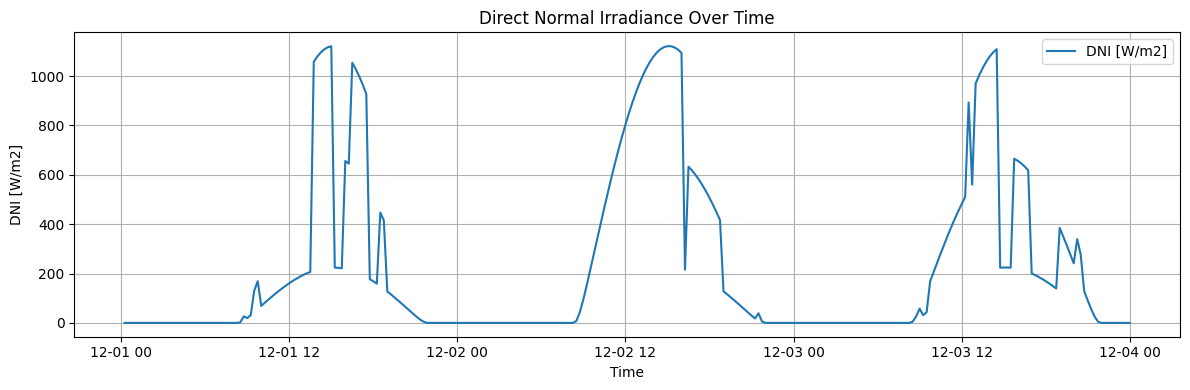

In [9]:
# Plot the solar irradiation as a function of time
df = pd.read_csv('results.csv', parse_dates=['date'], index_col='date')

dni_col = 'SolarIrradiation-0.SolarIrradiation_0-DNI[W/m2]'
if dni_col in df.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[dni_col], label='DNI [W/m2]')
    plt.xlabel('Time')
    plt.ylabel('DNI [W/m2]')
    plt.title('Direct Normal Irradiance Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{dni_col}' not found in results.csv")

Tensão nas barras

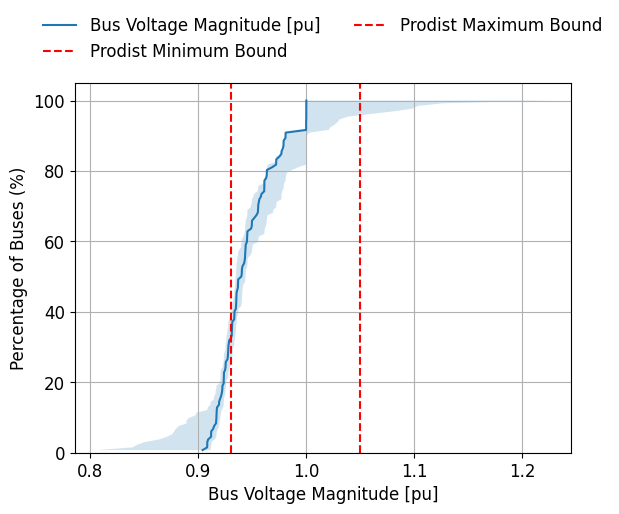

In [10]:
# Função para plotar CDF com sombra
def plot_cdf_with_shadow(data_mean, data_hi, data_lo, label):
    sorted_data_mean = np.sort(data_mean)
    #cdf = 100*np.arange(len(sorted_data_mean)) / float(len(sorted_data_mean))
    cdf = np.arange(1, len(sorted_data_mean) + 1) / len(sorted_data_mean) * 100

    
    sorted_data_hi = np.sort(data_hi)
    sorted_data_lo = np.sort(data_lo)
    
    plt.plot(sorted_data_mean, cdf, label=label)
    plt.fill_betweenx(cdf, sorted_data_lo, sorted_data_hi, alpha=0.2)


# Read the CSV file
df = pd.read_csv('results.csv', parse_dates=['date'], index_col='date')

# Filter columns that match the Bus voltage magnitude pattern
voltage_columns = [col for col in df.columns if re.search(r"Bus-\d+-Vm_[a|b|c]\[pu\]$", col)]
voltage_df = df[voltage_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': voltage_df.mean(),
    'Max': voltage_df.max(),
    'Min': voltage_df.min()
})


# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Voltage Magnitude [pu]')

plt.xlabel('Bus Voltage Magnitude [pu]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Perda de potência ativa nas barras

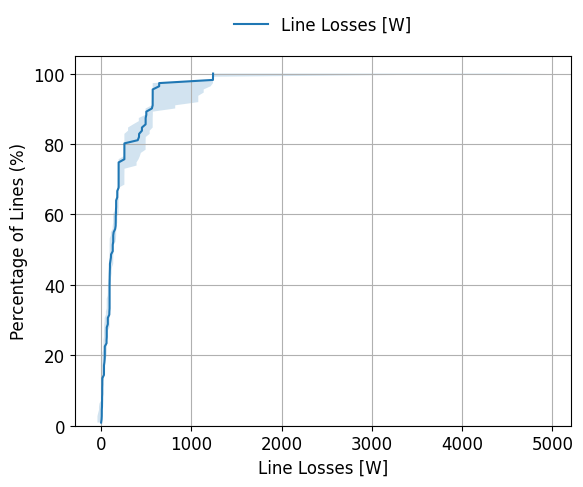

In [11]:

# Filter columns that match the Bus voltage magnitude pattern
loss_columns = [col for col in df.columns if re.search(r"Line-\d+-Pl_[a|b|c]\[MW\]$", col)]
loss_df = df[loss_columns]*1e6

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': loss_df.mean(),
    'Max': loss_df.max(),
    'Min': loss_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Losses [W]')

plt.xlabel('Line Losses [W]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Corrente de Neutro

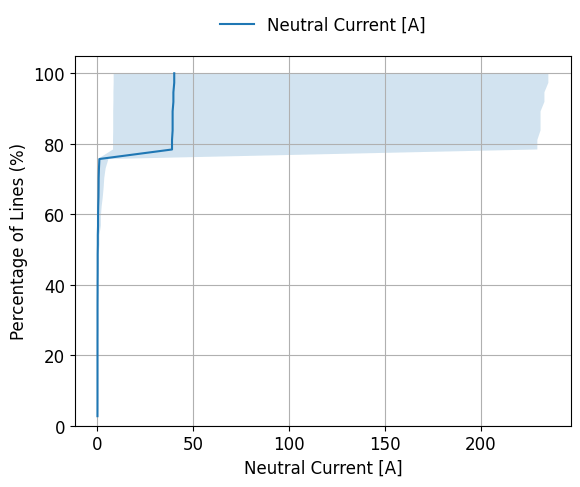

In [12]:
# Filter columns that match the Bus voltage magnitude pattern
neutral_current_columns = [col for col in df.columns if re.search(r"Line-\d+-I_n_from\[kA\]$", col)]
neutral_current_df = df[neutral_current_columns]*1e3

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': neutral_current_df.mean(),
    'Max': neutral_current_df.max(),
    'Min': neutral_current_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Neutral Current [A]')

plt.xlabel('Neutral Current [A]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Line Loading

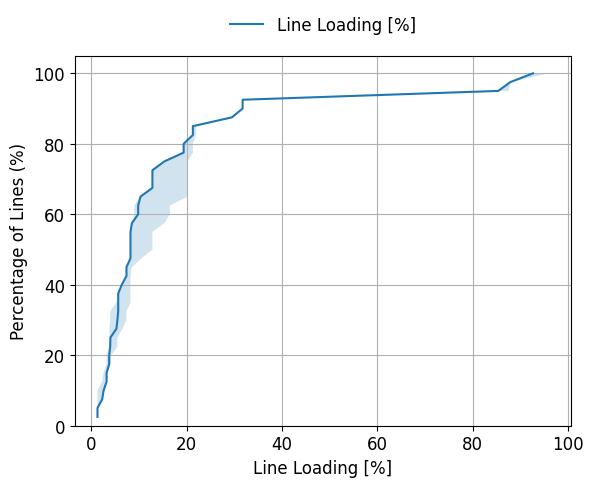

In [13]:
# Filter columns that match the Bus voltage magnitude pattern
line_loading_columns = [col for col in df.columns if re.search(r"Loading\[%\]$", col)]
line_loading_df = df[line_loading_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': line_loading_df.mean(),
    'Max': line_loading_df.max(),
    'Min': line_loading_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Loading [%]')

plt.xlabel('Line Loading [%]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Desbalanceamento de Barramentos

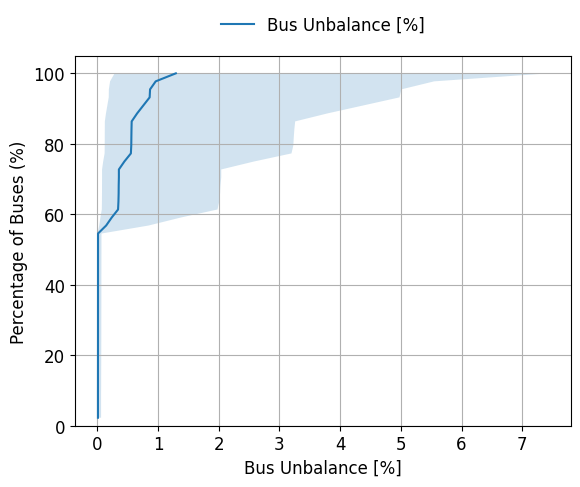

In [14]:

# Filter columns that match the Bus voltage magnitude pattern
unbalance_columns = [col for col in df.columns if re.search(r"Bus-\d+-Unbalance\[%\]$", col)]
unbalance_df = df[unbalance_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': unbalance_df.mean(),
    'Max': unbalance_df.max(),
    'Min': unbalance_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Unbalance [%]')

plt.xlabel('Bus Unbalance [%]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

